The Gibson Assembly® Protocol below is obtained from the New England Biolabs (NEB).
DOI: https://dx.doi.org/10.17504/protocols.io.bdddi226

v2.2 corresponds to the version of the process mapping document which can be found here:
https://imperiallondon.sharepoint.com/:w:/s/3rdYearGroupProject-Group1-BM/EUCI6zyDKR5Mu8h0xdkCKxsBZIlt9H7fuby1bR6irCJORQ?e=fNtstf

In [1]:
%reset

In [2]:
from logging import Logger
import os
import logging
import sbol3
import labop
import tyto
import uml
import json
import rdflib as rdfl
from typing import Dict, Tuple
from sbol3 import Document

from labop.execution_engine import ExecutionEngine
from labop_convert.opentrons.opentrons_specialization import OT2Specialization, REVERSE_LABWARE_MAP
from labop_convert.markdown.markdown_specialization import MarkdownSpecialization

from IPython.display import Image

# %load_ext autoreload
# %autoreload 2

/Users/jeytse/BMEY3_LabAutomationGroupProject/labOP_env/lib/python3.10/site-packages/sbol3/object.py:70: UserWarning: Using a default namespace. To set a namespace use set_namespace()
  warnings.warn('Using a default namespace.'


In [3]:
# set up the document
print('Setting up document')
doc = sbol3.Document()
sbol3.set_namespace('https://bmey3labautomation.com/')

Setting up document


In [4]:
# Import the primitive libraries
print('Importing libraries')
labop.import_library('liquid_handling')
print('... Imported liquid handling')
labop.import_library('plate_handling')
print('... Imported plate handling')
labop.import_library('spectrophotometry')
print('... Imported spectrophotometry')
labop.import_library('sample_arrays')
print('... Imported sample arrays')
labop.import_library('pcr')
print('... Imported pcr')

Importing libraries
... Imported liquid handling
... Imported plate handling
... Imported spectrophotometry
... Imported sample arrays
... Imported pcr


In [5]:
protocol = labop.Protocol('gibson_assembly_labop_v2_0')
protocol.name = "LabOP Opentrons Gibson Assembly Protocol"
doc.add(protocol)

# create the materials to be provisioned
CONT_NS = rdfl.Namespace('https://sift.net/container-ontology/container-ontology#')
OM_NS = rdfl.Namespace('http://www.ontology-of-units-of-measure.org/resource/om-2/')

PREFIX_MAP = json.dumps({"cont": CONT_NS, "om": OM_NS})

In [6]:
# Define reagents
# do we need to define all our reagents? if yes, how do we know which URI for our reagents?
dh2o = sbol3.Component('dH2O', 'https://pubchem.ncbi.nlm.nih.gov/substance/24901740')
dh2o.name = 'Water, sterile-filtered, BioReagent, suitable for cell culture'
doc.add(dh2o)

master_mix = sbol3.Component('master_mix', 'gibsonassemblymastermix')
master_mix.name = 'Gibson Assembly Master Mix'
doc.add(master_mix)

dna_frag1 = sbol3.Component('dna_frag1', 'dnafragments1')
dna_frag1.name = 'DNA Fragment 1'
doc.add(dna_frag1)

dna_frag2 = sbol3.Component('dna_frag2', 'dnafragments2')
dna_frag2.name = 'DNA Fragment 2'
doc.add(dna_frag2)

In [7]:
# Define labware
spec_reagent_plate = labop.ContainerSpec('reagent_plate',
                                    name='Well plate for reagents',
                                    queryString=REVERSE_LABWARE_MAP['nest_96_wellplate_200ul_flat'],
                                    # queryString='cont:NEST96WellPlate', # NEST 96 deep well plate
                                    prefixMap=PREFIX_MAP)
spec_destination_plate = labop.ContainerSpec('destination_plate',
                                        name='Destination plate',
                                        queryString=REVERSE_LABWARE_MAP['biorad_96_wellplate_200ul_pcr'],
                                        # queryString='cont:BioRad96WellPCRPlate', # NEST 96 PCR
                                        prefixMap=PREFIX_MAP)
spec_tiprack = labop.ContainerSpec('tiprack',
                                   name='tiprack',
                                   queryString=REVERSE_LABWARE_MAP['opentrons_96_tiprack_10ul'],
                                #    queryString='cont:Opentrons96TipRack10uL', # didn't have 20uL tiprack
                                   prefixMap=PREFIX_MAP)
p20 = sbol3.Agent('p20_single_gen2',
                  name='P20 Single GEN2')
thermocycler = sbol3.Agent('thermocycler_module',
                           name = 'Thermocycler Module')
doc.add(spec_tiprack)
doc.add(spec_reagent_plate)
doc.add(spec_destination_plate)
doc.add(p20)
doc.add(thermocycler)

tiprack = protocol.primitive_step('EmptyContainer',
                                  specification=spec_tiprack)
reagent_plate = protocol.primitive_step('EmptyContainer',
                                        specification=spec_reagent_plate)
destination_plate = protocol.primitive_step('EmptyContainer',
                                            specification=spec_destination_plate)

In [8]:
print(spec_destination_plate)
print(spec_reagent_plate)
print(spec_tiprack)

print(REVERSE_LABWARE_MAP['nest_96_wellplate_200ul_flat'])
print(REVERSE_LABWARE_MAP['biorad_96_wellplate_200ul_pcr'])
print(REVERSE_LABWARE_MAP['opentrons_96_tiprack_10ul'])

<ContainerSpec https://bmey3labautomation.com/destination_plate>
<ContainerSpec https://bmey3labautomation.com/reagent_plate>
<ContainerSpec https://bmey3labautomation.com/tiprack>
https://sift.net/container-ontology/container-ontology#NEST96WellPlate
https://sift.net/container-ontology/container-ontology#BioRad96WellPCRPlate
https://sift.net/container-ontology/container-ontology#Opentrons96TipRack10uL


In [9]:
# Load OT2 robot with labware
left_pipette = protocol.primitive_step('ConfigureRobot', 
                                      #  instrument=OT2Specialization.EQUIPMENT['p20_single_gen2'],
                                      instrument=p20,
                                       mount='left')
thermocycler_module = protocol.primitive_step('ConfigureRobot',
                                              instrument=thermocycler,
                                            #   instrument=OT2Specialization.EQUIPMENT['thermocycler'],
                                              mount='7')
tiprack = protocol.primitive_step('LoadRackOnInstrument',
                                  rack=spec_tiprack,
                                  coordinates='1')
load_reagent_plate = protocol.primitive_step('LoadRackOnInstrument',
                                             rack=spec_reagent_plate,
                                             coordinates='4')
load_destination_plate = protocol.primitive_step('LoadContainerOnInstrument',
                                                 specification=spec_destination_plate,
                                                 instrument=thermocycler,
                                                #  instrument=OT2Specialization.EQUIPMENT['thermocycler'],
                                                 slots='A1:H12') # 96 wells

In [10]:
# Set up target samples
assembly_reaction = protocol.primitive_step('PlateCoordinates',
                                            source=load_destination_plate.output_pin('samples'),
                                            coordinates='A1:H1')
negative_control = protocol.primitive_step('PlateCoordinates',
                                           source=load_destination_plate.output_pin('samples'),
                                           coordinates='A2:H2')

In [11]:
# Set up reagents - assuming reagents are loaded onto reagent plate manually
master_mix_well = protocol.primitive_step('PlateCoordinates',
                                          source=reagent_plate.output_pin('samples'),
                                          coordinates='A1')
dh2o_well = protocol.primitive_step('PlateCoordinates',
                                    source=reagent_plate.output_pin('samples'),
                                    coordinates='A2')
dna_frag1_well = protocol.primitive_step('PlateCoordinates',
                                         source=reagent_plate.output_pin('samples'),
                                         coordinates='A3')
dna_frag2_well = protocol.primitive_step('PlateCoordinates',
                                         source=reagent_plate.output_pin('samples'),
                                         coordinates='A4')

In [12]:
# Protocol
# does the 'Transfer' primitive step automatically change tip?

# hold = protocol.primitive_step('Hold',
#                                location=thermocycler,
#                                temperature=sbol3.Measure(4.0,tyto.OM.degree_Celsius))
# hold.name = '1. Set thermocycler to hold at 4 degrees Celsius while setting up assembly reaction and negative control'

# 'Hold' primitive step isn't defined for OT2Specialization, so gotta improvise with 'PCR'
pcr = protocol.primitive_step('PCR',
                              denaturation_temp=sbol3.Measure(0, tyto.OM.degree_Celsius),
                              denaturation_time=sbol3.Measure(0, tyto.OM.minute),
                              annealing_temp=sbol3.Measure(0, tyto.OM.degree_Celsius),
                              annealing_time=sbol3.Measure(0, tyto.OM.second),
                              extension_temp=sbol3.Measure(0, tyto.OM.degree_Celsius),
                              extension_time=sbol3.Measure(0, tyto.OM.second),
                              cycles=1)
pcr.name = '1. Hold at 4 degrees Celsius'

transfer = protocol.primitive_step('Transfer',
                                   source=dh2o_well.output_pin('samples'),
                                   destination=assembly_reaction.output_pin('samples'),
                                   amount=sbol3.Measure(10,tyto.OM.microliter))
transfer.name = '2. Add deionized H2O for assembly reaction (first transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=dh2o_well.output_pin('samples'),
                                   destination=assembly_reaction.output_pin('samples'),
                                   amount=sbol3.Measure(6,tyto.OM.microliter))
transfer.name = '2. Add deionized H2O for assembly reaction (second transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=dh2o_well.output_pin('samples'),
                                   destination=negative_control.output_pin('samples'),
                                   amount=sbol3.Measure(10,tyto.OM.microliter))
transfer.name = '3. Add deionized H2O for negative control (first transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=dh2o_well.output_pin('samples'),
                                   destination=negative_control.output_pin('samples'),
                                   amount=sbol3.Measure(6,tyto.OM.microliter))
transfer.name = '3. Add deionized H2O for negative control (second transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=master_mix_well.output_pin('samples'),
                                   destination=assembly_reaction.output_pin('samples'),
                                   amount=sbol3.Measure(10,tyto.OM.microliter))
transfer.name = '4. Add Gibson Assembly Master Mix for assembly reaction (first transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=master_mix_well.output_pin('samples'),
                                   destination=assembly_reaction.output_pin('samples'),
                                   amount=sbol3.Measure(10,tyto.OM.microliter))
transfer.name = '4. Add Gibson Assembly Master Mix for assembly reaction (second transfer)'


transfer = protocol.primitive_step('Transfer',
                                   source=dh2o_well.output_pin('samples'),
                                   destination=negative_control.output_pin('samples'),
                                   amount=sbol3.Measure(10,tyto.OM.microliter))
transfer.name = '5. Add deionized H2O instead of Gibson Assembly Master Mix for negative control (first transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=dh2o_well.output_pin('samples'),
                                   destination=negative_control.output_pin('samples'),
                                   amount=sbol3.Measure(10,tyto.OM.microliter))
transfer.name = '5. Add deionized H2O instead of Gibson Assembly Master Mix for negative control (second transfer)'

transfer = protocol.primitive_step('Transfer',
                                   source=dna_frag1_well.output_pin('samples'),
                                   destination=assembly_reaction.output_pin('samples'),
                                   amount=sbol3.Measure(2,tyto.OM.microliter))
transfer.name = '6. Add DNA fragment 1 for assembly reaction'

transfer = protocol.primitive_step('Transfer',
                                   source=dna_frag1_well.output_pin('samples'),
                                   destination=negative_control.output_pin('samples'),
                                   amount=sbol3.Measure(2,tyto.OM.microliter))
transfer.name = '7. Add DNA fragment 1 for negative control'

transfer = protocol.primitive_step('Transfer',
                                   source=dna_frag2_well.output_pin('samples'),
                                   destination=assembly_reaction.output_pin('samples'),
                                   amount=sbol3.Measure(2,tyto.OM.microliter))
transfer.name = '8. Add DNA fragment 2 for assembly reaction'

transfer = protocol.primitive_step('Transfer',
                                   source=dna_frag2_well.output_pin('samples'),
                                   destination=negative_control.output_pin('samples'),
                                   amount=sbol3.Measure(2,tyto.OM.microliter))
transfer.name = '9. Add DNA fragment 2 for negative control'

# how to accommodate mixing 20uL (half of total volume) if pipette tip max is 10uL
mix = protocol.primitive_step('PipetteMix',
                              samples=assembly_reaction.output_pin('samples'),
                              amount=sbol3.Measure(10,tyto.OM.microliter),
                              cycleCount=5)
mix.name = '10. Mix 5 times'

# incubate = protocol.primitive_step('Incubate',
#                                    location=thermocycler,
#                                    duration=sbol3.Measure(15,tyto.OM.minute),
#                                    temperature=sbol3.Measure(50,tyto.OM.degree_Celsius))
# incubate.name = 'Incubate at 50 degrees Celsius for 15 minutes'

# pcr = protocol.primitive_step('PCR',
#                               denaturation_temp=sbol3.Measure(98.0, tyto.OM.degree_Celsius),
#                               denaturation_time=sbol3.Measure(10, tyto.OM.second),
#                               annealing_temp=sbol3.Measure(45.0, tyto.OM.degree_Celsius),
#                               annealing_time=sbol3.Measure(5, tyto.OM.second),
#                               extension_temp=sbol3.Measure(65.0, tyto.OM.degree_Celsius),
#                               extension_time=sbol3.Measure(60, tyto.OM.second),
#                               cycles=30)
# pcr.name = 'test pcr primitive step'
pcr = protocol.primitive_step('PCR',
                              denaturation_temp=sbol3.Measure(50, tyto.OM.degree_Celsius),
                              denaturation_time=sbol3.Measure(15, tyto.OM.minute),
                              annealing_temp=sbol3.Measure(0, tyto.OM.degree_Celsius),
                              annealing_time=sbol3.Measure(0, tyto.OM.second),
                              extension_temp=sbol3.Measure(0, tyto.OM.degree_Celsius),
                              extension_time=sbol3.Measure(0, tyto.OM.second),
                              cycles=1)
pcr.name = '11. Incubate at 50 degrees Celsius for 15 minutes'

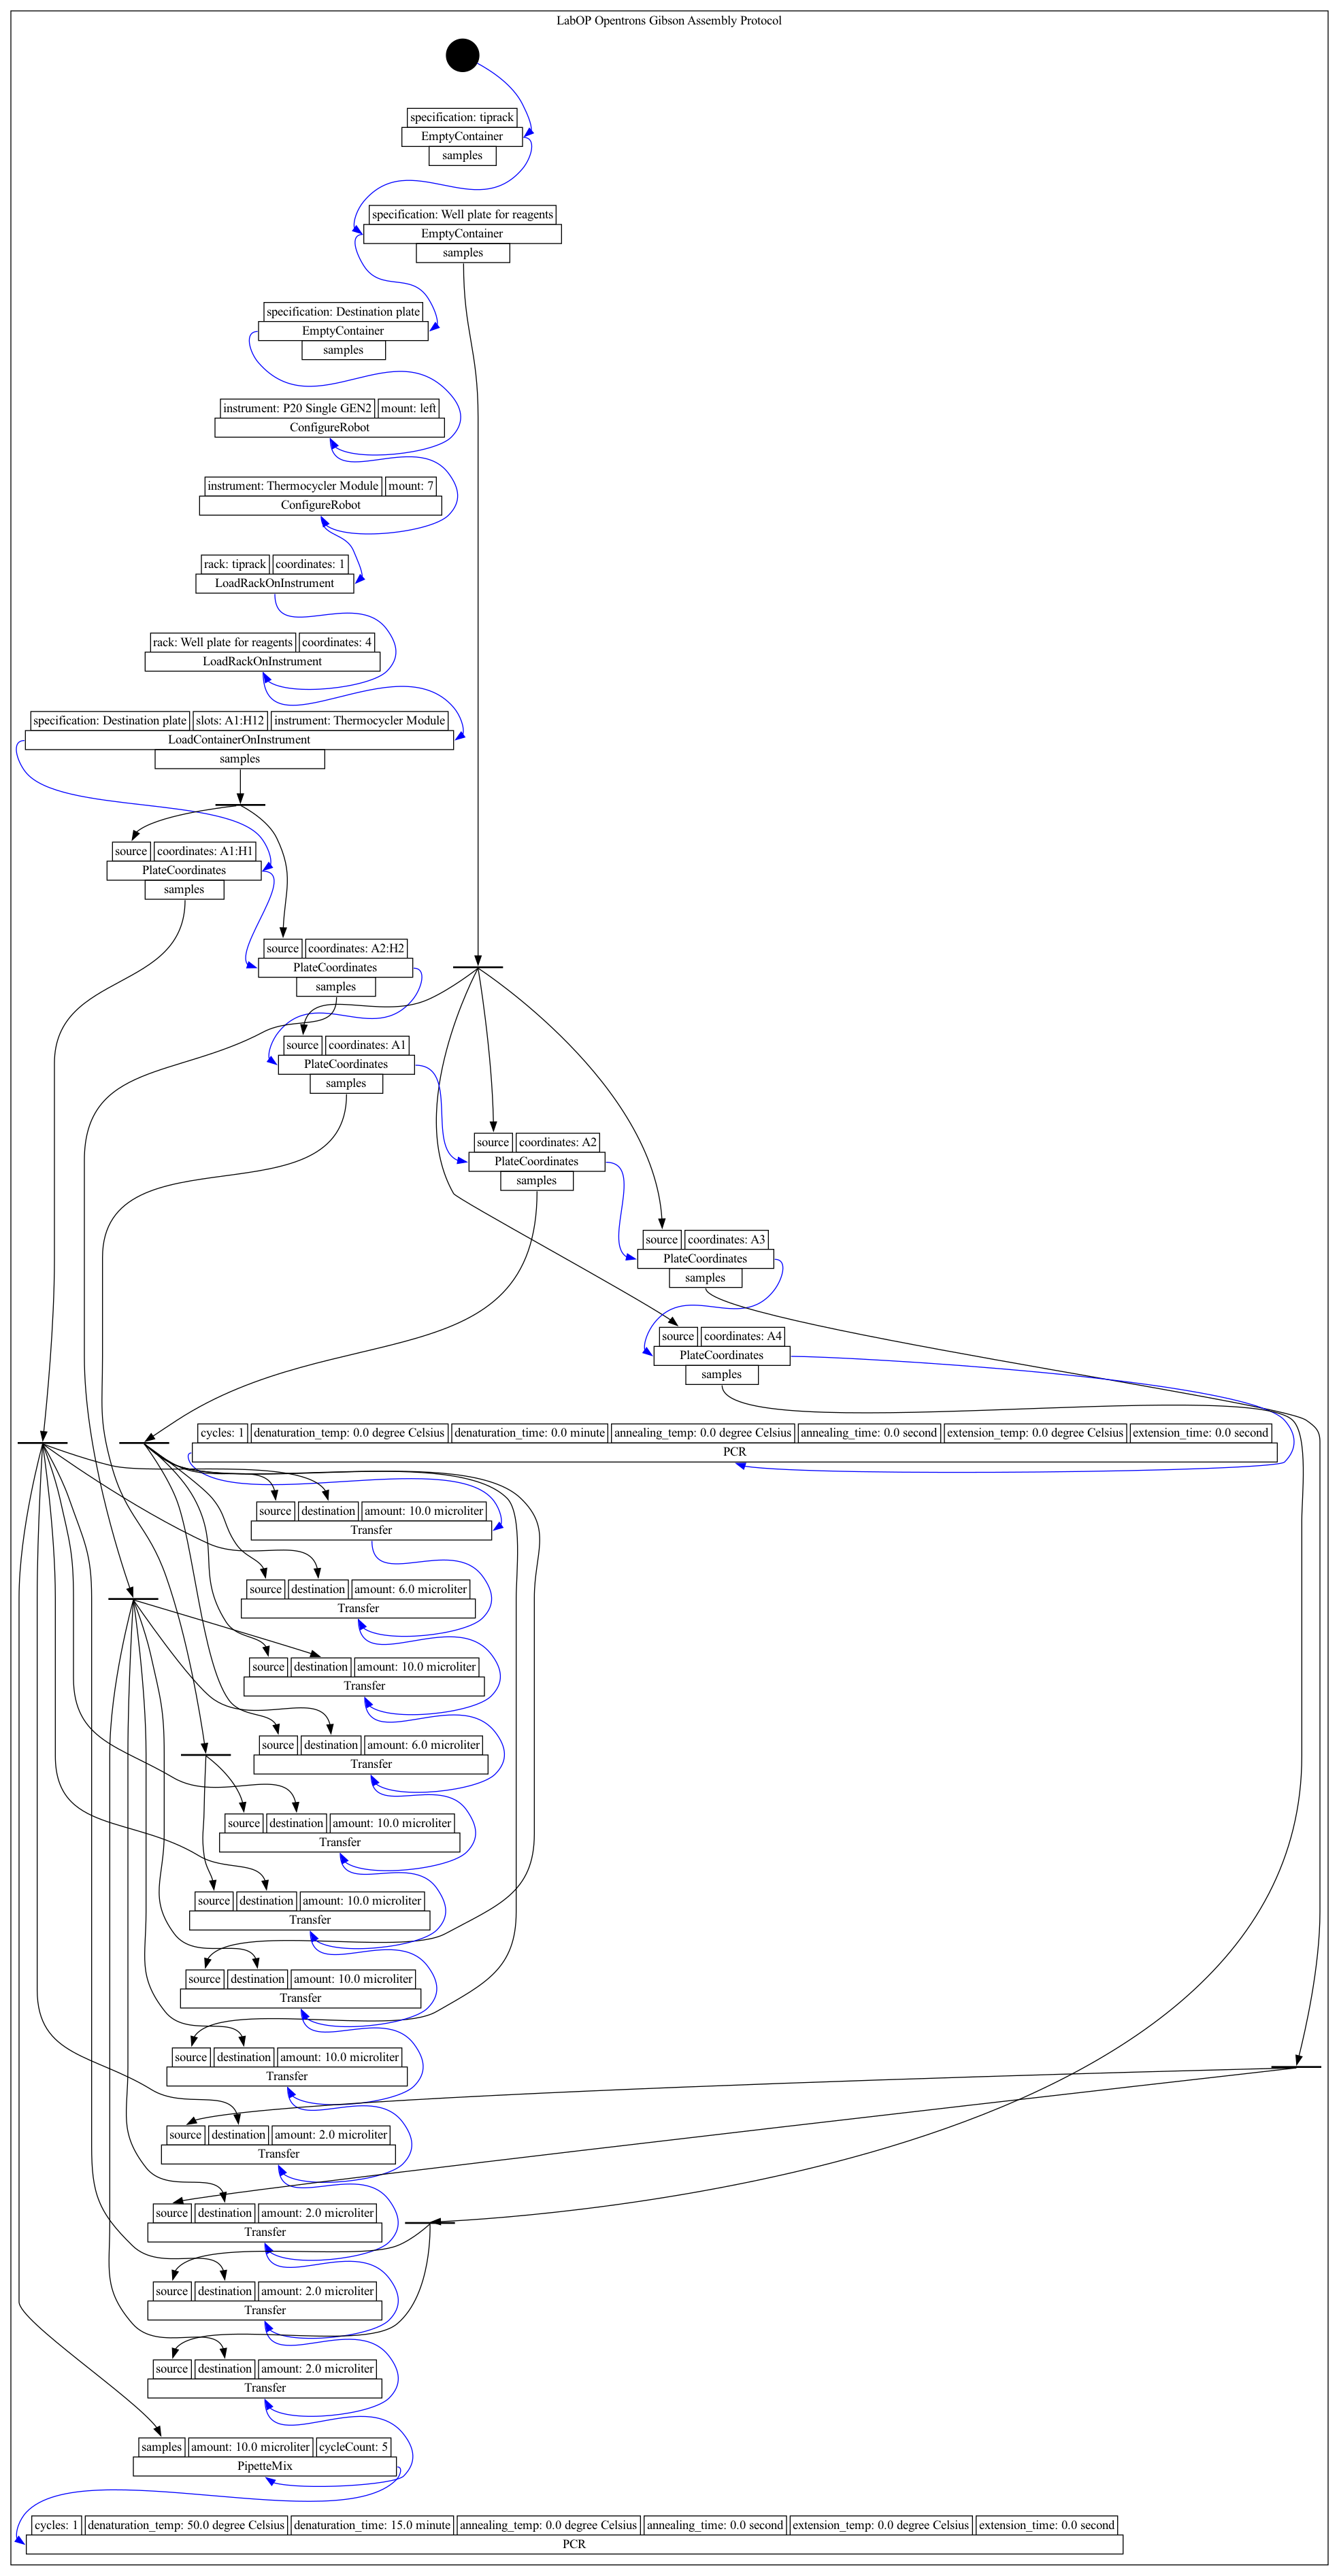

In [13]:
out_dir = os.path.join(os.path.abspath(""), "test")
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

protocol.to_dot().render(filename=os.path.join(out_dir,protocol.display_name), format='png')

Image(os.path.join(out_dir, protocol.display_name+".png"))

In [14]:
filename = 'ot2_gibson_assembly_labop'
# filename = os.path.join(out_dir, "ot2_gibson_assembly_labop") # out_dir currently points to test
agent = sbol3.Agent('ot2_machine', name='OT2 machine')
ee = ExecutionEngine(specializations=[OT2Specialization(filename)])
parameter_values = []
execution = ee.execute(protocol, agent, id='test_execution')

Successful execution. Script dumped to ot2_gibson_assembly_labop.
